In [1]:
import numpy as np
# np.random.seed(129803)

import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/lsimek/matplotlibrc/main/navy.mplstyle')

import seaborn as sns

import scipy.stats as stats
import scipy.linalg as linalg
from scipy.spatial import ConvexHull

import os
import sys

In [2]:
def chull_plot(ax, vertices, hull, colorid='2', lw=1.5, style='--', **kwargs):
    hv = hull.vertices
    hv = np.hstack((hv, hv[0]))
    
    ax.plot(vertices[hv,0], vertices[hv,1], linestyle=style, lw=lw, color=f'C{colorid}', **kwargs)

In [3]:
def chull_area(vertices, hull):
    x = vertices[hull.vertices, 0]
    y = vertices[hull.vertices, 1]

    yl = np.roll(y, shift=-1, axis=0)
    yr = np.roll(y, shift=1, axis=0)

    return 1/2 * ( np.sum(x*yl) - np.sum(x*yr) )

In [4]:
def get_walk(n=100, drift_vec=np.array([0,0]), sigma=1):
    w  = np.random.normal(size=(n-1,2))
    w = np.vstack((np.array([0,0]),w))

    drift = np.tile(drift_vec,n).reshape(n,2)

    return w.cumsum(axis=0) + ( drift.cumsum(axis=0) - drift_vec )

In [5]:
def plot_walk(ax, w, **kwargs):
    ax.plot(w[:, 0], w[:, 1], **kwargs)

In [6]:
def perp(v):
    return v[:, [1,0]] * np.array([-1, 1])

In [7]:
def maxmin(w,midx,Midx,**kwargs):
    n = w.shape[0]
    
    # izbaciti one u unutrasnjosti
    e1l = np.vstack(( w[0,:], w[midx,:] ))
    e2l = np.vstack(( w[midx,:], w[-1,:] ))

    e1u = np.vstack(( w[0,:], w[Midx,:] ))
    e2u = np.vstack(( w[Midx,:], w[-1,:] ))

    vl = e2l - e1l
    vu = e2u - e1u

    above_l = perp(vl) @ w.T >= np.sum(e1l*perp(vl),axis=1).reshape(2,-1)
    above_l = np.all(above_l,axis=0)

    below_u = perp(vu) @ w.T <= np.sum(e1u*perp(vu),axis=1).reshape(2,-1)
    below_u = np.all(below_u,axis=0)

    inside = above_l & below_u
    wout = w[~inside,:]
    
    # projekcije
    e1 = np.vstack(( e1l, e1u ))
    e2 = np.vstack(( e2l, e2u ))
    v = np.vstack(( vl, vu ))
    v_norm = v / np.linalg.norm(v, axis=1).reshape(4,-1)  # some vectors can be null, will throw warnings
    
    proj = np.abs( perp(v_norm) @ wout.T - np.sum(perp(v_norm)*e1, axis=1).reshape(4,-1) )
    
    # we consider distances to lines
    # the distance to the segment may not be the same
    # but it "usually" is and the other thing is complicated to implement
    minidx = np.argmin(proj, axis=0)
    mins = proj[minidx, np.arange(len(wout))]

    maxidx = np.argmax(mins)
    maxdist = mins[maxidx]
    a = wout[maxidx, :]

    # proj_v = v_norm[minidx[maxidx], :].reshape(1, 2)

    # temp = proj_v-a
    # proj_target = a - (perp(temp) + e1[minidx[maxidx], :]) * maxdist
    # proj_target = proj_target.flatten()
    
    # # nacratti segment od a do a + proj_target * maxdist_proj
    # print(f'{minidx=}; {mins=}; {maxidx=}; {maxdist=}; {a=}; {proj_target=}; {proj_v=}')

    
    # ax = kwargs.get('ax')
    # if ax is not None:
    #     ax.plot(
    #         [a[0], proj_target[0]],
    #         [a[1], proj_target[1]],
    #         lw=2,
    #         color='red',
    #         linestyle=':'
    #     )

    return {
        'percent_inside': 1-len(wout)/n,
        'maxdist': maxdist
    }

## trying it out

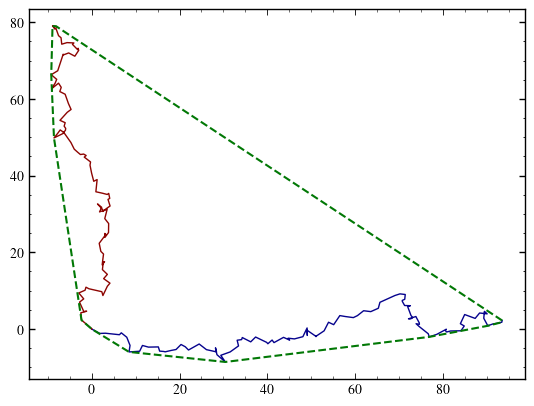

In [8]:
fig, ax = plt.subplots()

n = 100
w1 = get_walk(n, np.array([1,0]), sigma=2)
w2 = get_walk(n, np.array([0,1]), sigma=3)

ax.plot(w1[:,0],w1[:,1])
ax.plot(w2[:,0],w2[:,1])

allw = np.vstack((w1,w2))
hull = ConvexHull(allw)
chull_plot(ax, allw, hull)

## calculate area of hull?

In [9]:
n = 1000
nsim = 4500
areas = []

for _ in range(nsim):
    w1 = get_walk(n, np.array([1,0]), sigma=1)
    w2 = get_walk(n, np.array([0,1]), sigma=1)
    
    allw = np.vstack((w1,w2))
    hull = ConvexHull(allw)

    areas.append(chull_area(allw, hull))

## growth?

In [10]:
ns = np.arange(5000, 10000, 500)

nsim = 500
areas = {n:[] for n in ns}

for n in ns:
    for _ in range(nsim):
        w1 = get_walk(n, np.array([1,0]), sigma=1)
        w2 = get_walk(n, np.array([0,1]), sigma=1)
        
        allw = np.vstack((w1,w2))
        hull = ConvexHull(allw)
    
        areas[n].append(chull_area(allw, hull))

In [11]:
areas = {n: np.array(li) for n, li in areas.items()}
avgs = {n: np.mean(arr) for n,arr in areas.items()}

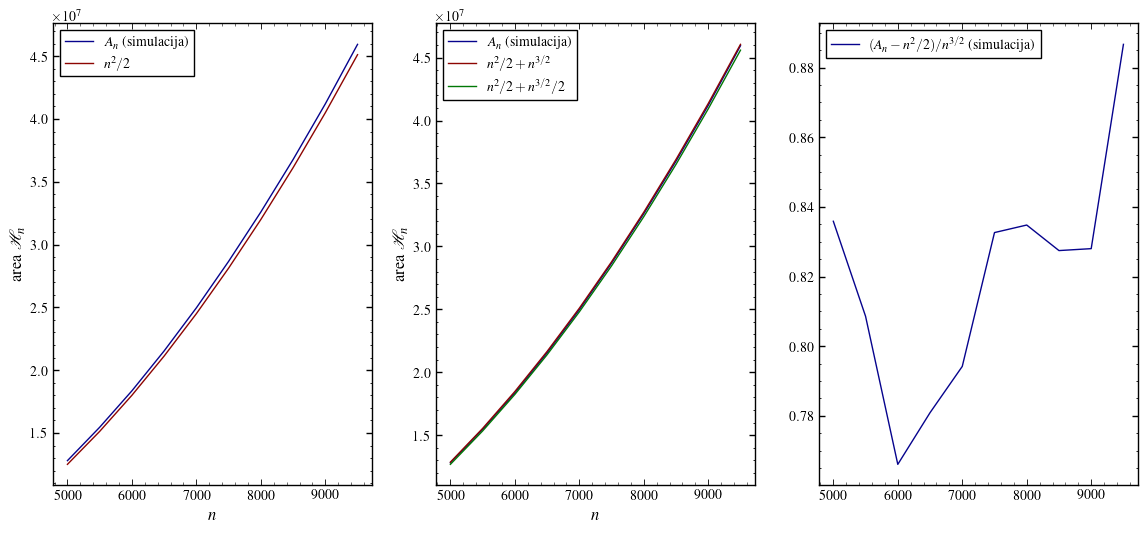

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,6))
sns.lineplot(x=ns, y=avgs.values(), ax=ax1, label=r'$A_n$ (simulacija)')
sns.lineplot(x=ns, y=ns**2/2, ax=ax1, label=r'$n^2/2$')

sns.lineplot(x=ns, y=avgs.values(), ax=ax2, label=r'$A_n$ (simulacija)')
sns.lineplot(x=ns, y=ns**2/2+ns**1.5, ax=ax2, label=r'$n^2/2+n^{3/2}$')
sns.lineplot(x=ns, y=ns**2/2+ns**1.5/2, ax=ax2, label=r'$n^2/2+n^{3/2}/2$')

ax1.set_xlabel(r'$n$')
ax1.set_ylabel(r'area $\mathcal H_n$')
ax2.set_xlabel(r'$n$')
ax2.set_ylabel(r'area $\mathcal H_n$')


sns.lineplot(x=ns, y= [np.mean((arr - n**2/2)/n**1.5) for n, arr in areas.items()], ax=ax3, label=r'$(A_n-n^2/2)/n^{3/2}$ (simulacija)')

plt.savefig('../images/2setnje_rast.png')

### distribution of $(A_n-n^2/2)/n^{3/2}$

<Axes: ylabel='Density'>

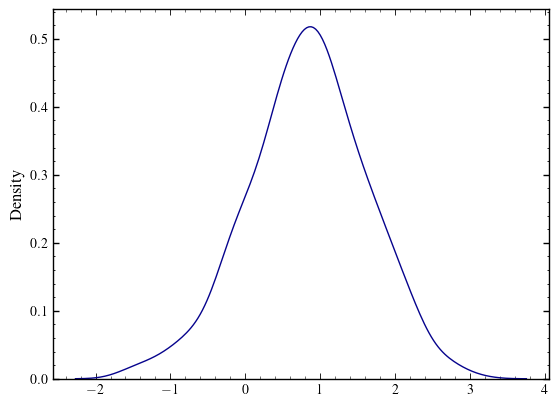

In [13]:
n = 9000
f = lambda x: (x-n**2/2)/n**1.5
x = f(areas[n])
sns.kdeplot(x)

In [14]:
stats.shapiro(x)

ShapiroResult(statistic=np.float64(0.9962936756481762), pvalue=np.float64(0.2979876252290958))

## $m_n$ and $M_n$ (extremal points with respect to line from $0$ to $S_n$)

In [21]:
n=500
w = get_walk(n=n, drift_vec=np.array([1,0]))

Sn = w[n-1:].flatten()
e = np.array([ -Sn[1], Sn[0] ]) / np.linalg.norm(Sn) # -> \mu^perp g.s.

In [22]:
proj = np.dot(w, e)
midx = np.argmin(proj)
Midx = np.argmax(proj)

tripl = w[[0, midx, n-1, 0]]
tripu = w[[0, Midx, n-1, 0]]

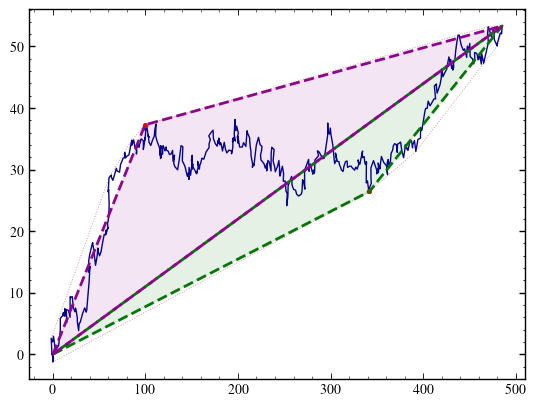

In [23]:
fig, ax = plt.subplots()
plot_walk(ax, w)

ax.plot(w[midx, 0], w[midx, 1], 'ro')
ax.plot(tripl[:, 0], tripl[:, 1], linestyle='--', lw=2, color=f'C2', alpha=1)
ax.fill(tripl[:, 0], tripl[:, 1], color='C2', alpha=0.1)

ax.plot(w[Midx, 0], w[Midx, 1], 'ro', alpha=1)
ax.plot(tripu[:, 0], tripu[:, 1], linestyle='--', lw=2, color=f'C4', alpha=1)
ax.fill(tripu[:, 0], tripu[:, 1], color='C4', alpha=0.1)

chull_plot(ax, w, ConvexHull(w), colorid='1', lw=0.7, style=':', alpha=0.4)

## Does $\rho_H(\mathcal H_n, T_n)/\sqrt n \rightarrow 0$?

In [18]:
ns = np.arange(1000, 20000, 1000)
nsim = 500

dist = {n:[] for n in ns}
pct = {n:[] for n in ns}

for i,n in enumerate(ns):
    for j in range(nsim):

        w = get_walk(n=n, drift_vec=np.array([1,0]))
    
        Sn = w[n-1:].flatten()
        e = np.array([ -Sn[1], Sn[0] ]) / np.linalg.norm(Sn) # -> \mu^perp g.s.
    
        proj = np.dot(w, e)
        midx = np.argmin(proj)
        Midx = np.argmax(proj)
        
        di = maxmin(w, midx, Midx)
        maxdist = di.get('maxdist')

        if not np.isnan(maxdist):
            dist[n].append(maxdist)
        pct[n].append(di.get('percent_inside'))

eksp = 0.5
dist = {
    n:np.mean(np.array(li)/n**eksp) for n, li in dist.items()
}

/tmp/ipykernel_29762/822990228.py:27: RuntimeWarning: invalid value encountered in divide
  v_norm = v / np.linalg.norm(v, axis=1).reshape(4,-1)  # some vectors can be null, will throw warnings


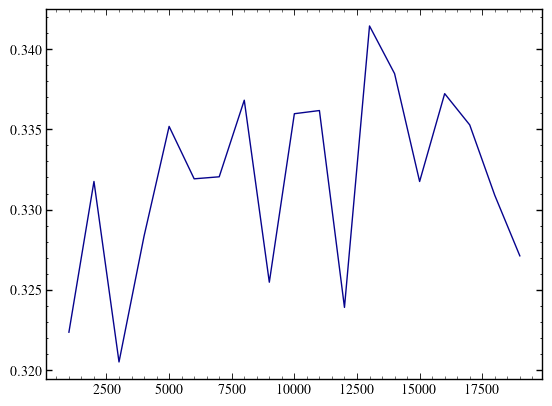

In [19]:
fig, ax = plt.subplots()
ax.plot(dist.keys(), dist.values())

## Bonus: which % of points are inside the double-triangle-hull

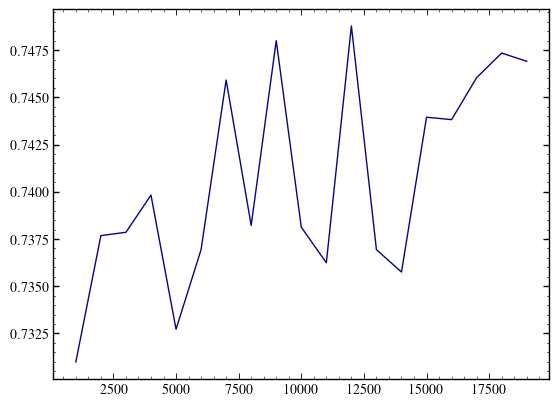

In [20]:
pct = {n:np.mean(np.array(li)) for n, li in pct.items()}

fig, ax = plt.subplots()
ax.plot(pct.keys(), pct.values())